# ARMAモデルに従う時系列の次時刻予測を、ARモデルだとして、statsmodelsで行う。（最小二乗法）

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

In [2]:
sm.__version__

'0.12.0'

### ARMAモデルに従う時系列の作成

In [3]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [1, -0.5]
p = len(phi_a)
q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

### 設定したパラメータが反転可能かどうかを確認（＝方程式の解が全て1より大きいならok）

In [4]:
print(np.abs(np.roots(np.append([-phi_a[p-i-1] for i in range(p)],1))))#ARのパラメタ
print(np.abs(np.roots(np.append([-phi_b[q-i-1] for i in range(q)],1))))#MAのパラメタ

[1.2250 1.2250 1.2907 1.2907]
[1.4142 1.4142]


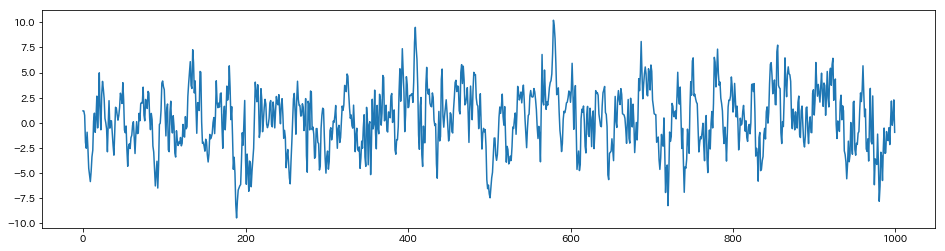

In [5]:
plt.figure(figsize=(16,4))
plt.plot(data)

### 推定に用いる$\hat p$を決定

#### まずはARMAモデルを想定したaic判定

In [6]:
order_select = sm.tsa.arma_order_select_ic(y=data, max_ar=5, max_ma=3, ic='aic')
order_select

{'aic':              0            1            2            3
 0  5031.497587  4033.920825  3759.358788  3760.459557
 1  4142.386715  3778.508994  3722.329472  3708.458197
 2  4130.956134  3771.693652  3723.553322  3703.285873
 3  3888.280533  3530.942112  3489.193842  3478.033925
 4  3589.807928  3471.346987  3472.535297  3474.064748
 5  3523.935129  3472.675521  3473.874817  3475.846974,
 'aic_min_order': (4, 1)}

あれ、既にずれてる？（本当は(4,2)）

#### 次にARモデルを想定したaic判定

In [7]:
ar_order_select = sm.tsa.arma_order_select_ic(y=data, max_ar=20, max_ma=0, ic='aic')
ar_order_select

{'aic':               0
 0   5031.497587
 1   4142.386715
 2   4130.956134
 3   3888.280533
 4   3589.807928
 5   3523.935129
 6   3488.574333
 7   3483.209741
 8   3480.085327
 9   3480.737137
 10  3481.628243
 11  3478.953872
 12  3480.719222
 13  3482.657544
 14  3484.655495
 15  3485.175993
 16  3487.072782
 17  3488.355420
 18  3490.325261
 19  3491.238457
 20  3491.887553, 'aic_min_order': (11, 0)}

In [8]:
min_aic = ar_order_select.aic.iloc[ar_order_select.aic_min_order[0], 0]
min_aic

3478.95387200504

In [9]:
ar_order_select.aic.columns=["AIC"]

<Figure size 1152x288 with 0 Axes>

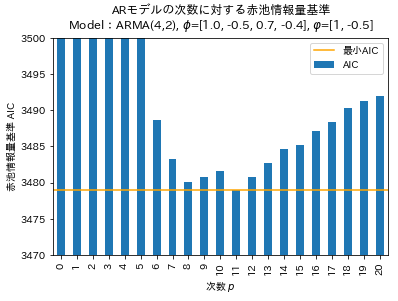

In [15]:
# fig = plt.figure(figsize=(16,4))
# ax = fig.add_subplot(nrows=1, ncols=1, index=1)
# ar_order_select.aic.plot(ax=ax)
plt.figure(figsize=(16,4))
ar_order_select.aic.plot(kind='bar', label="AIC")
plt.title("ARモデルの次数に対する赤池情報量基準\nModel：ARMA(4,2), $\\phi$={0}, $\\varphi$={1}".format(phi_a,phi_b))
plt.ylim(3470, 3500)
plt.xticks(ticks=np.arange(start=0,stop= 21, step=1))
plt.xlabel("次数 $p$")
plt.ylabel("赤池情報量基準 AIC")
plt.axhline(y=min_aic, color="orange", label="最小AIC")
plt.legend()
plt.savefig(os.environ['HOME']+"/Downloads/ARMA_AIC_plot.png")
plt.show()